# vSEIR model in monkeypox modelling


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
data = pd.read_csv('timeseries-country-confirmed.csv',usecols=['Date','Cases','Country'])
C1=data[data['Country']=='United States']
C1=C1[C1['Date']>'2022/5/17']
date = np.array(C1['Date'].astype(str))
xs = [datetime.strptime(d, '%Y/%m/%d').date() for d in date]
C=C1['Cases'].values

array([  0,   1,   4,   0,   1,   3,   1,   3,   2,   3,   0,   1,   3,
         3,   5,   6,  10,   4,   1,   3,  15,   7,   7,   6,  14,  12,
         9,   9,  24,  14,  18,  19,  17,  14,  16,  17,  26,  33,  35,
        32,  23,  67,  56,  64,  71,  63,  48,  48,  46, 108,  95, 112,
       127,  77,  60, 209, 158, 191, 193, 224, 110,  77, 313, 291, 290,
       259, 328, 154, 108, 539, 381, 477, 349, 398, 191, 143, 645, 442,
       529, 526, 437, 167, 147, 806, 508, 655, 412, 413, 183, 131, 785,
       368, 473, 379, 423, 157,  99, 896, 640, 335, 450, 327,  80,  44,
       533, 439, 266, 446, 369,  45,  20,  25, 677, 117], dtype=int64)

In [3]:
C1

,Date,Cases,Country
7693,2022/5/18,0,United States
7694,2022/5/19,1,United States
7695,2022/5/20,4,United States
7696,2022/5/21,0,United States
7697,2022/5/22,1,United States
...,...,...,...
7802,2022/9/4,45,United States
7803,2022/9/5,20,United States
7804,2022/9/6,25,United States
7805,2022/9/7,677,United States


In [4]:
def moving_average(interval, windowsize):
    window = np.ones(int(windowsize)) / float(windowsize)
    re = np.convolve(interval, window, 'same')
    return re

array([  0.71428571,   0.85714286,   1.28571429,   1.42857143,
         1.85714286,   2.        ,   1.85714286,   1.85714286,
         1.85714286,   1.85714286,   2.14285714,   2.42857143,
         3.        ,   4.        ,   4.57142857,   4.57142857,
         4.57142857,   6.28571429,   6.57142857,   6.71428571,
         6.14285714,   7.57142857,   9.14285714,  10.        ,
         9.14285714,  11.57142857,  12.57142857,  14.28571429,
        15.        ,  15.71428571,  16.42857143,  17.42857143,
        16.42857143,  18.14285714,  20.28571429,  22.57142857,
        24.71428571,  26.        ,  33.28571429,  38.85714286,
        44.28571429,  49.71428571,  53.71428571,  56.        ,
        59.57142857,  56.57142857,  64.        ,  68.42857143,
        74.28571429,  83.42857143,  87.57142857,  89.28571429,
       112.57142857, 119.71428571, 133.42857143, 145.        ,
       158.85714286, 163.57142857, 166.        , 180.85714286,
       199.85714286, 214.        , 223.42857143, 238.28

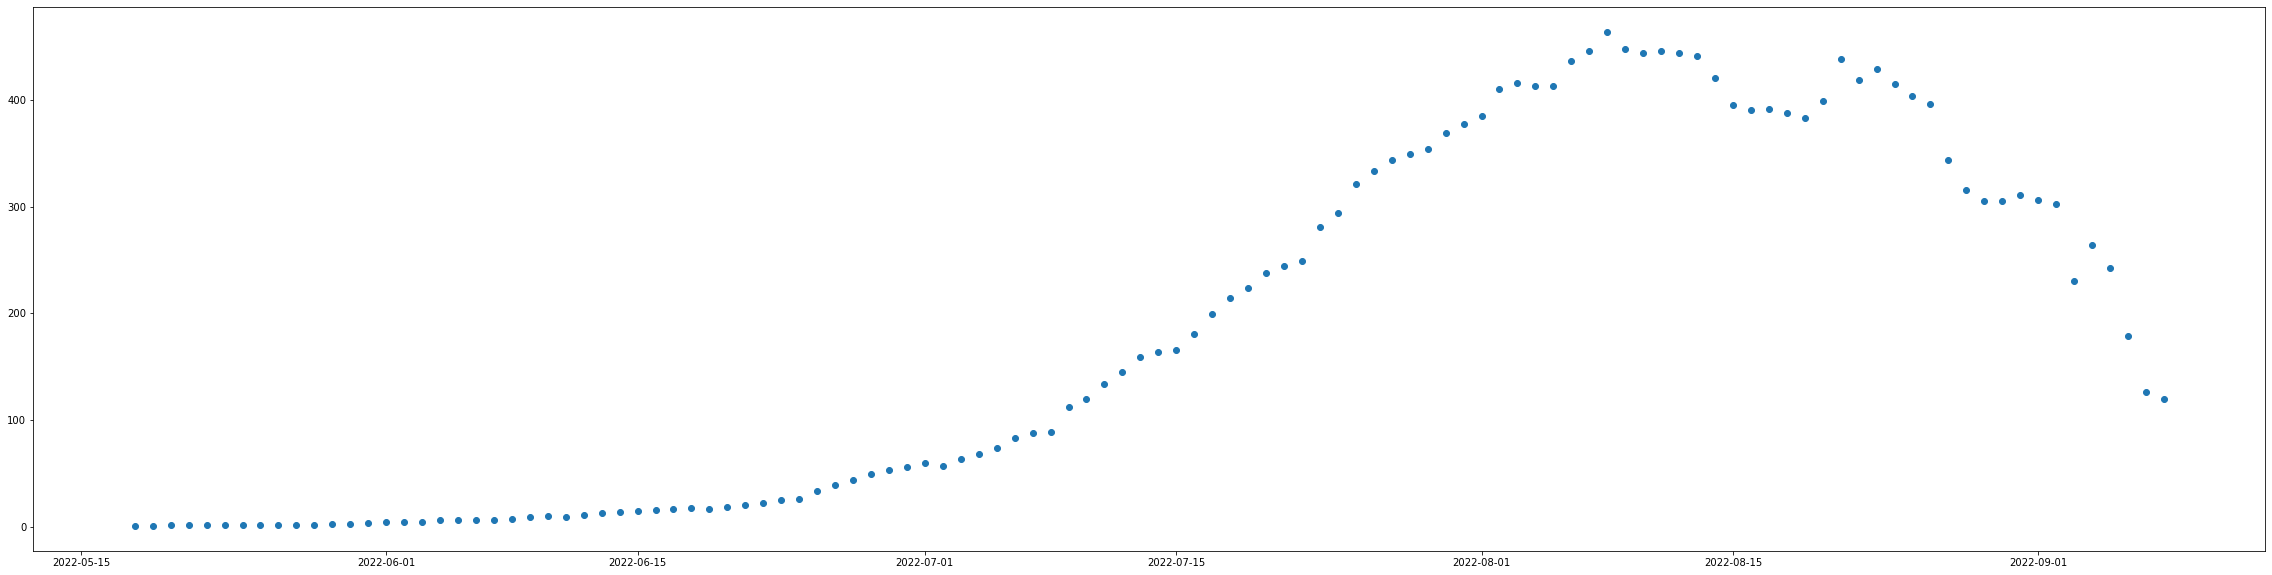

In [5]:
C =moving_average(C,7)
C
plt.figure(figsize=(40, 10))
plt.scatter(xs,C)
C

In [6]:
def RLS(x,y):
    l=0.65 
    R={};z={};P={};w={};k={}
    R[0]=x[0]*x[0]
    z[0]=x[0]*y[0]
    P[0]=1/R[0]
    w[0]=(1/R[0])*z[0]
    for i in range(1,len(x)):
        k[i]=(P[i-1]*x[i])/(l+x[i]*P[i-1]*x[i])
        P[i]=(1/l)*P[i-1]-(1/l)*k[i]*x[i]*P[i-1]
        w[i]=w[i-1]-k[i]*(x[i]*w[i-1]-y[i])
    return w
      


In [7]:
q=1/8.7
E=np.zeros(len(C))
for i in range(len(C)):
    E[i]=C[i]/q #估计E,E时变

In [8]:
Su={};I={};SA={};X={};Y={};Bu={};R={};T={};Rt={};
Ep={};
theta=0.76#55以下占比
SA[0]=332854719*(1-theta)
Su[0]=332854719*theta
I[0]=26#当前感染者
Ep[0]=26*8#感染者乘以8
R[0]=0
T[0]=0
d=0.0081
N=332854719#地区总人数
q=1/8.7 #潜伏期倒数 转化率
g=1/21 #康复率 感染时间倒数
for t in range(len(C)-1):
        I[t + 1] = I[t] + 0.983* q * E[t] - g * I[t]
        R[t + 1] = R[t] + g *(1-0.983)* E[t] + g * I[t] 
        Y[t] = E[t + 1] - E[t] + I[t+1]-I[t] +R[t+1]-R[t]
        X[t] = (0.15 * SA[t] * I[t] + Su[t] * I[t]) / N
        Bu = RLS(X, Y)
        SA[t + 1] = SA[t] - Bu[t] * 0.15 * SA[t] * I[t] / N
        Su[t + 1] = Su[t] - Bu[t] * Su[t] * I[t] / N
        Rt[t] = 0.983 / g  * (Bu[t] * 0.15 * SA[t] + Bu[t] * Su[t]) / N
        Ep[t + 1] = Ep[t] + Bu[t] * 0.15 * SA[t] * I[t] / N + Bu[t] * Su[t] * I[t] / N - q * Ep[t]
        T[t + 1] = T[t] + 0.983* q * Ep[t]
#for t in range(len(C) - 1):
#    Y[t] = E[t + 1] - E[t] + I[t+1]- I[t] +R[t+1]-R[t]
#    X[t] = (0.15 * SA[t] * I[t] + Su[t] * I[t]) / N
#    Bu = RLS(X, Y)
#    Rt[t] = q / (g * (q + g)) * (Bu[t] * 0.15 * SA[t] + Bu[t] * Su[t]) / N


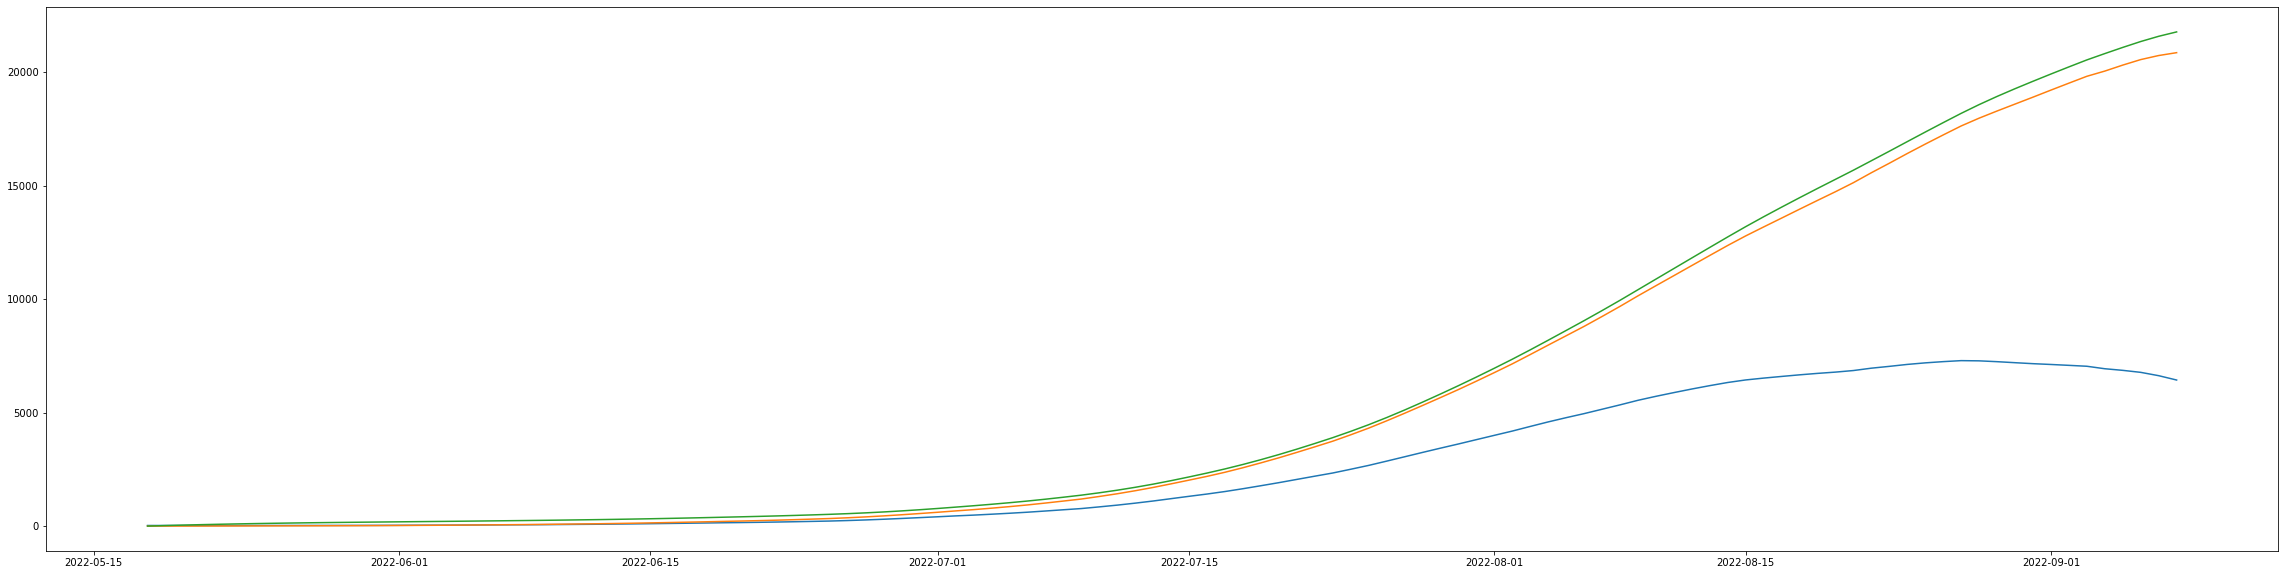

In [9]:
lst = list(I.values())
plt.figure(figsize=(40, 10))
plt.plot(xs,lst)
total={}
total[0]=0
for i in range(len(C)-1):
    total[i+1]=total[i]+C[i]
plt.plot(xs,list(total.values()))
plt.plot(xs,list(T.values()))

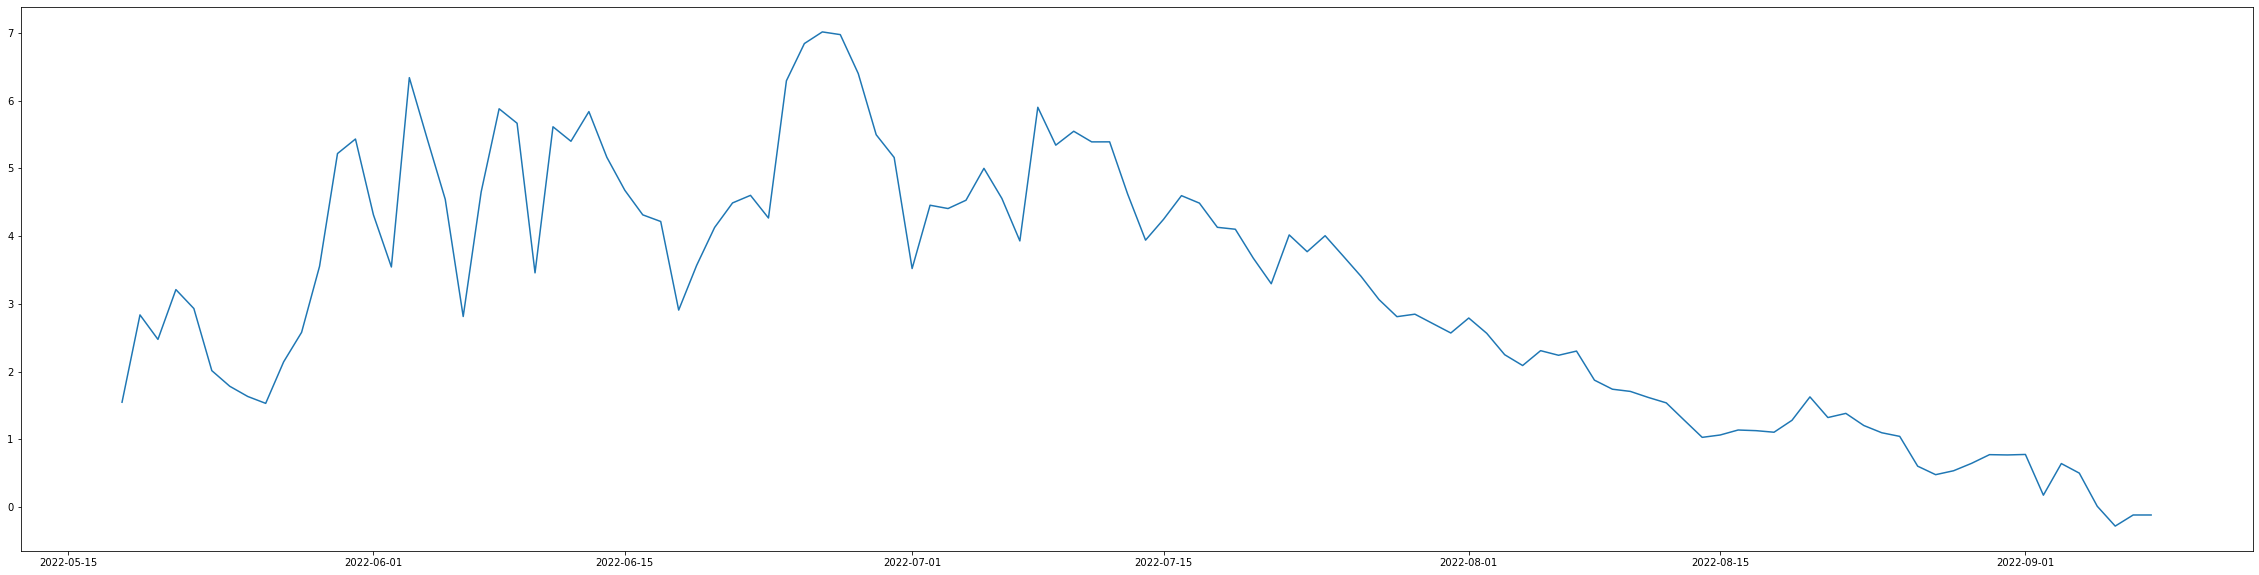

In [10]:
plt.figure(figsize=(40, 10))
Rt[len(C)-1]=Rt[len(C)-2]
plt.plot(xs,list(Rt.values()))

# vSEIRD model in COVID-19 modelling

In [11]:
data = pd.read_csv('USA.csv')
C1=data['United States']
C2=data['Death']
date = np.array(data['Date'].astype(str))
xs = [datetime.strptime(d, '%Y/%m/%d').date() for d in date]
C=C1.values
Cr=C2.values
C

array([    2,     1,     0,     1,     0,     0,     0,     0,     1,
           1,     3,     4,     2,     0,     0,     1,     0,     0,
           0,     0,     2,     1,     1,     0,     0,     2,     5,
           3,     1,     5,     8,     0,     4,     4,     8,     5,
           4,     9,    18,    35,    51,    70,    78,   130,   146,
         214,   391,   497,   529,   734,   954,  1219,  2161,  2366,
        3214,  4891,  6111,  7544,  9148, 10854, 10691, 11397, 14091,
       18560, 20211, 20822, 26346, 15291, 23754, 28447, 29976, 31784,
       32556, 27081, 28642, 29267, 34310, 34877, 32724, 32126, 27194,
       25021, 25185, 25308, 31763, 30311, 27728, 27007, 26152, 25301,
       31221, 33111, 34985, 32838, 26630, 24024, 23767, 27060, 31411,
       32038, 28297, 26748, 21515, 22894, 25472, 29335, 28083, 25919,
       21648, 19711, 24133, 17464, 34534, 26790], dtype=int64)

In [12]:
def RLS(x,y):
    l=0.4
    R={};z={};P={};w={};k={}
    R[0]=x[0]*x[0]
    z[0]=x[0]*y[0]
    P[0]=1/R[0]
    w[0]=(1/R[0])*z[0]
    for i in range(1,len(x)):
        k[i]=(P[i-1]*x[i])/(l+x[i]*P[i-1]*x[i])
        P[i]=(1/l)*P[i-1]-(1/l)*k[i]*x[i]*P[i-1]
        w[i]=w[i-1]-k[i]*(x[i]*w[i-1]-y[i])
    return w

array([2.85714286e-01, 2.85714286e-01, 3.57142857e-01, 4.28571429e-01,
       6.42857143e-01, 9.28571429e-01, 1.07142857e+00, 1.07142857e+00,
       9.28571429e-01, 9.28571429e-01, 9.28571429e-01, 8.57142857e-01,
       8.57142857e-01, 8.57142857e-01, 1.00000000e+00, 1.07142857e+00,
       1.07142857e+00, 1.00000000e+00, 7.85714286e-01, 6.42857143e-01,
       8.57142857e-01, 1.07142857e+00, 1.14285714e+00, 1.42857143e+00,
       2.00000000e+00, 2.00000000e+00, 2.28571429e+00, 2.57142857e+00,
       3.00000000e+00, 3.28571429e+00, 3.50000000e+00, 4.14285714e+00,
       5.42857143e+00, 7.78571429e+00, 1.10714286e+01, 1.58571429e+01,
       2.13571429e+01, 3.02857143e+01, 4.01428571e+01, 5.54285714e+01,
       8.30714286e+01, 1.18285714e+02, 1.55500000e+02, 2.07571429e+02,
       2.75428571e+02, 3.61857143e+02, 5.14928571e+02, 6.81428571e+02,
       9.07357143e+02, 1.25171429e+03, 1.68264286e+03, 2.21221429e+03,
       2.85521429e+03, 3.61521429e+03, 4.35092857e+03, 5.12950000e+03,
      

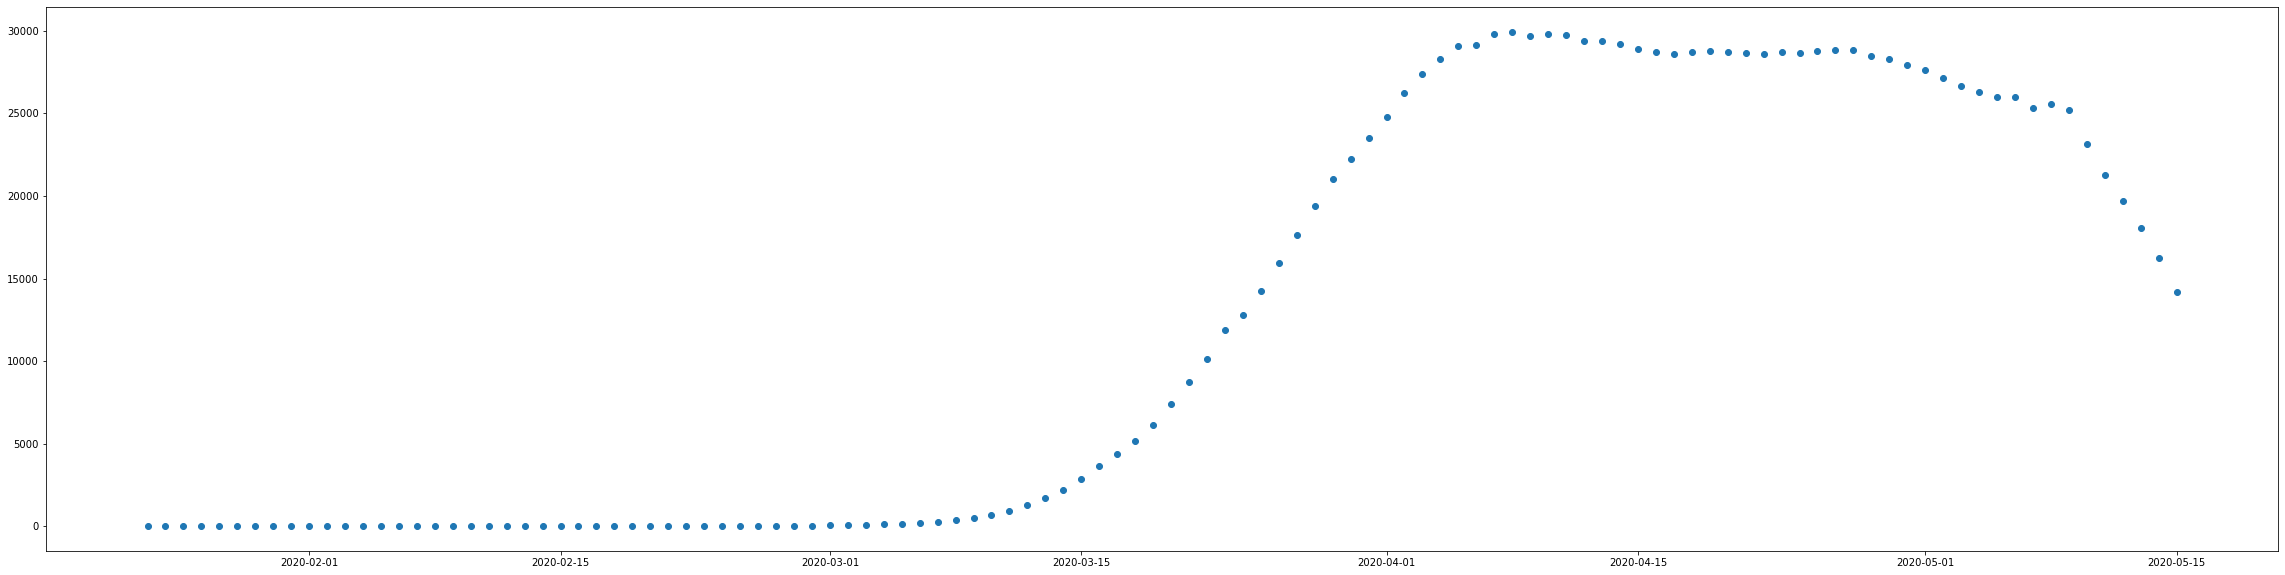

In [13]:
C =moving_average(C,14)
plt.figure(figsize=(40, 10))
plt.scatter(xs,C)
C

In [14]:
q=1/6.2
Ec=np.zeros(len(C))
for i in range(len(C)):
    Ec[i]=C[i]/q #估计E,E时变

In [15]:
Suc={};Ic={};SAc={};Xc={};Yc={};Buc={};Rc={};Tc={};Rtc={};
Epc={};Rd={};Yr={};Xr={};
Suc[0]=332854719
Ic[0]=18#当前感染者
Epc[0]=18*6#感染者乘以8
Rc[0]=0
Tc[0]=0
Rd[0]=0
d=0.0081
Nc=332854719#地区总人数
q=1/6.2 #潜伏期倒数 转化率
g=1/21 #康复率 感染时间倒数
gd={};
N=332854719
for t in range(len(C)-1):
    Ic[t + 1] = Ic[t] + 1* q * Ec[t] - g * Ic[t]
    Rc[t + 1] = Rc[t] + g * Ic[t] 
    Yc[t] = Ec[t + 1] - Ec[t] + Ic[t+1]-Ic[t] +Rc[t+1]-Rc[t]
    Xc[t] = ( Suc[t] * Ic[t]) / N
    Buc=RLS(Xc,Yc)
    Yr[t]=Cr[t+1]-Cr[t]
    Xr[t]=Ic[t]
    gd = RLS(Xr,Yr)
    Suc[t+1]=Suc[t]-Buc[t]*Suc[t]*Ic[t]/Nc
    Epc[t+1]=Epc[t]+Buc[t]*Suc[t]*Ic[t]/Nc-q*Epc[t]
    Tc[t+1]=Tc[t]+q*Epc[t]
    Rtc[t]=(Buc[t]*Suc[t])/((g+gd[t])*Nc)


dict_values([0, 17.419354838709676, 32.0752192656459, 44.46294703507204, 54.96795725181871, 63.99282350384776, 71.87734537524061, 78.791068615776, 84.81478859815321, 89.97475292414545, 94.43669390848426, 98.32306883390969, 101.68722117983637, 104.6340598163245, 107.23883944047748, 109.64596088763041, 111.89367734588845, 113.97469792192793, 115.85945985988229, 117.46302292234354, 118.80715729539122, 120.12533778155793, 121.51700449365434, 122.94534543708454, 124.53222136939553, 126.50624089558379, 128.61434687054094, 130.94340474099286, 133.52803282781028, 136.4770600929169, 139.74288492256156, 143.26454609148192, 147.30105548676346, 152.37017674813745, 159.38160986975788, 169.33010670285248, 183.68959360673193, 203.57637662627758, 231.98209124948, 270.6175896018004, 324.2498895275022, 403.83000489976246, 518.648149071342, 673.4052226639336, 881.2697399288813, 1158.1313645611933, 1523.021293960427, 2033.411583512708, 2716.3820865423595, 3627.559454616315, 4875.1558361792595, 6558.209682

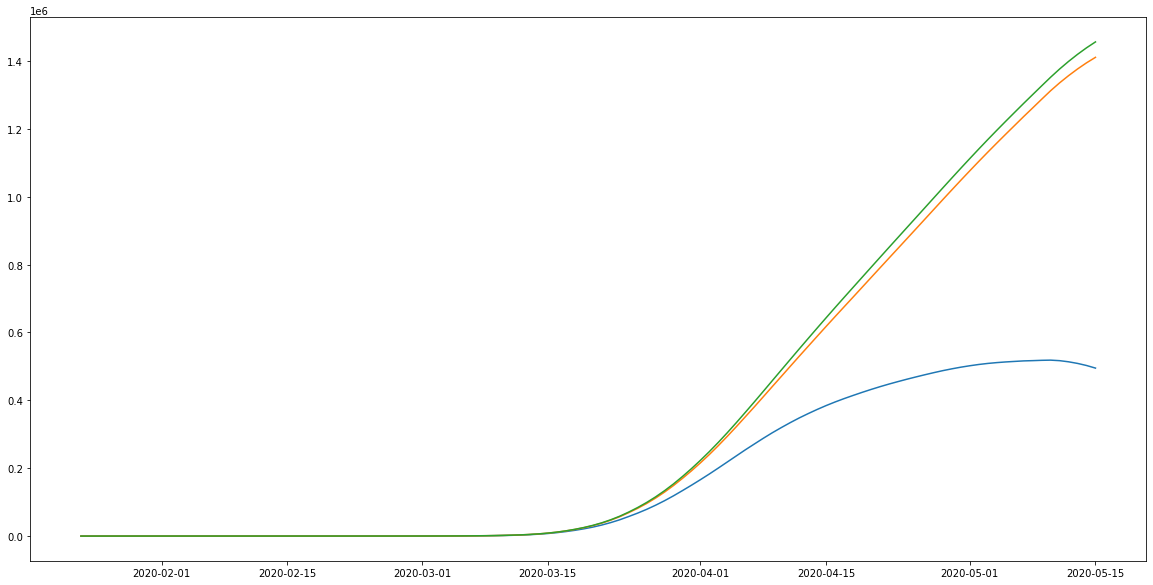

In [16]:
lst = list(Ic.values())
plt.figure(figsize=(20, 10))
plt.plot(xs,lst)
total={}
total[0]=0
for i in range(len(C)-1):
    total[i+1]=total[i]+C[i]
plt.plot(xs,list(total.values()))
plt.plot(xs,list(Tc.values()))
Tc.values()

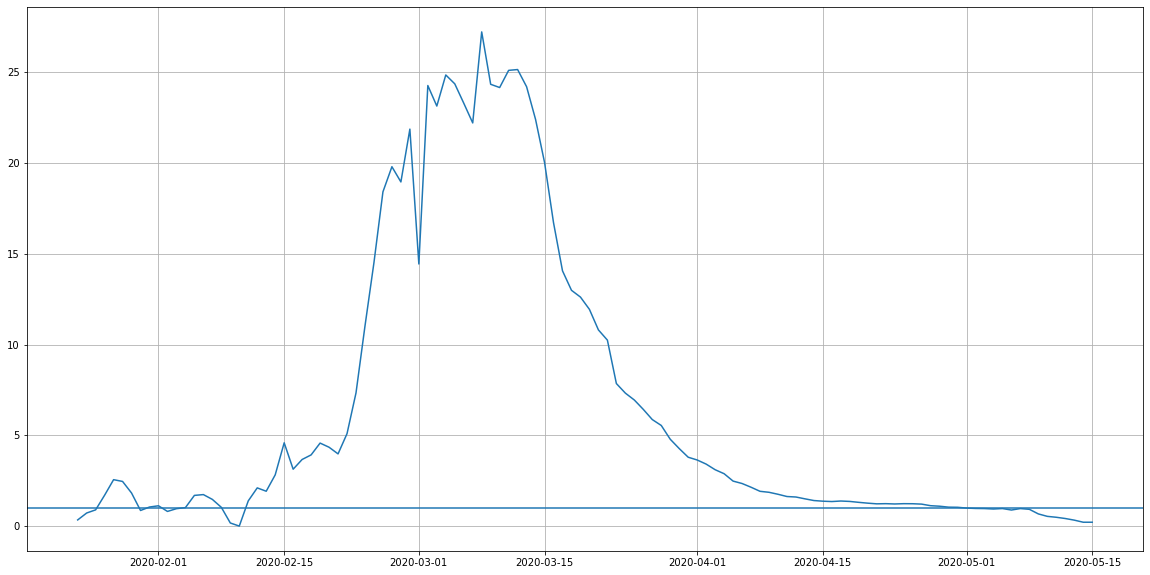

In [17]:
plt.figure(figsize=(20, 10))
Rtc[len(C)-1]=Rtc[len(C)-2]
plt.plot(xs,list(Rtc.values()))
plt.grid()
plt.axhline(y=1)